# Load Images

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
tf.__version__

'2.4.1'

In [3]:
import pathlib

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [5]:
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
print(data_dir)

228818944/228813984 [==============================] - 8s 0us/step
/root/.keras/datasets/flower_photos


In [6]:
!mv /root/.keras/datasets/flower_photos ./flowers

In [7]:
data_dir = pathlib.Path('./flowers')
print(data_dir)

flowers


In [8]:
type(data_dir)

pathlib.PosixPath

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


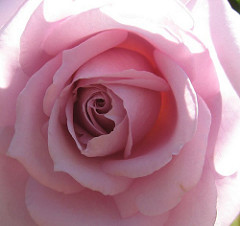

In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(roses[0])

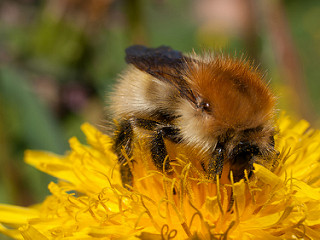

In [11]:
dandelion = list(data_dir.glob('dandelion/*'))
PIL.Image.open(dandelion[0])

## Create dataset

In [12]:
type(PIL.Image.open(dandelion[0]))

PIL.JpegImagePlugin.JpegImageFile

In [13]:
dandelion0 = PIL.Image.open(dandelion[0])
dandelion0_array = np.array(dandelion0)
print(dandelion0_array.shape)

(240, 320, 3)


In [14]:
batch_size = 32
img_height = 180
img_width = 180

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               validation_split=0.2,
                                                               subset='training',
                                                               seed=21,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                             validation_split=0.2,
                                                             subset='validation',
                                                             batch_size=batch_size,
                                                             image_size=(img_height, img_width),
                                                             seed=21)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [17]:
class_names = train_ds.class_names

In [18]:
for images, labels in train_ds.take(1):
    print(labels)

tf.Tensor([1 3 3 3 1 0 4 1 0 2 1 3 3 2 2 4 3 1 3 4 0 4 2 3 3 4 2 2 3 2 2 4], shape=(32,), dtype=int32)


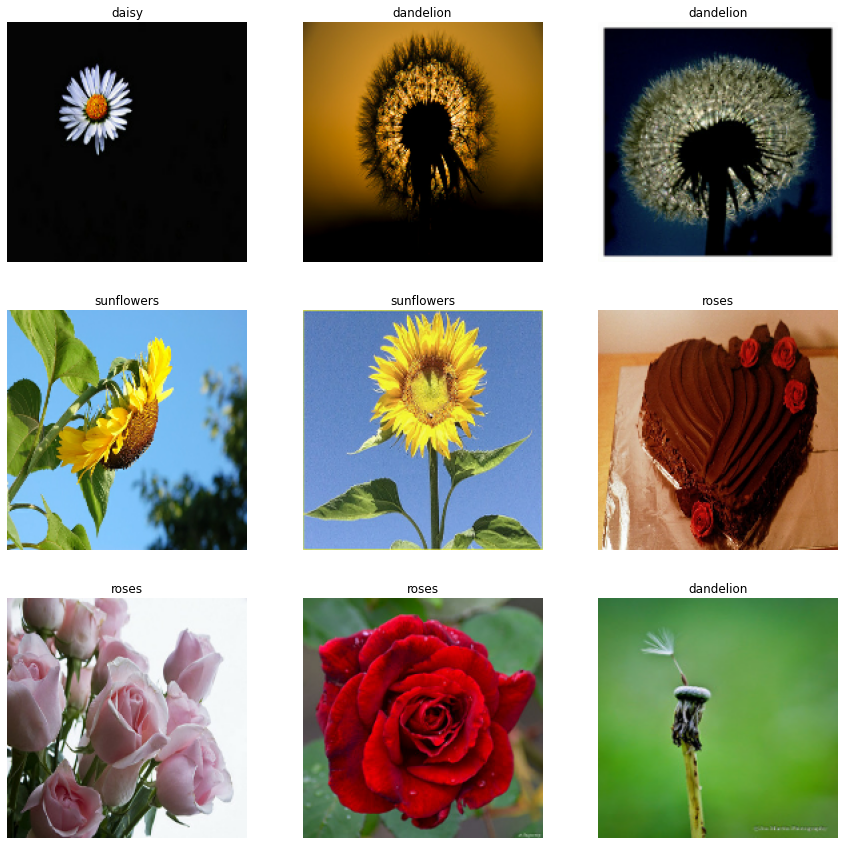

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i, ax in zip(range(9), axes.flatten()):
        ax.set_title(class_names[labels[i]])
        ax.imshow(images[i].numpy().astype('uint8'))
        ax.set_axis_off()

In [20]:
for images_batch, labels_batch in train_ds:
    print(images_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [21]:
from tensorflow.keras import layers

In [22]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)

In [27]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
next_image, next_label = next(normalized_ds.as_numpy_iterator())
flatten_next_image = next_image.reshape(-1, 1)
print(np.min(flatten_next_image[0]))
print(np.max(flatten_next_image[0]))

0.27278867
0.27278867


In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255),
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((3, 3)),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5)
])

In [36]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [37]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
92/92 [==============================] - 5s 47ms/step - loss: 1.6161 - accuracy: 0.2525 - val_loss: 1.3495 - val_accuracy: 0.4060
Epoch 2/50
92/92 [==============================] - 4s 44ms/step - loss: 1.3302 - accuracy: 0.4213 - val_loss: 1.1135 - val_accuracy: 0.4700
Epoch 3/50
92/92 [==============================] - 4s 44ms/step - loss: 1.2070 - accuracy: 0.4653 - val_loss: 1.0609 - val_accuracy: 0.5341
Epoch 4/50
92/92 [==============================] - 4s 44ms/step - loss: 1.1340 - accuracy: 0.5188 - val_loss: 0.9336 - val_accuracy: 0.5954
Epoch 5/50
92/92 [==============================] - 4s 44ms/step - loss: 0.9931 - accuracy: 0.5967 - val_loss: 1.0010 - val_accuracy: 0.6226
Epoch 6/50
92/92 [==============================] - 4s 44ms/step - loss: 0.9422 - accuracy: 0.6132 - val_loss: 0.8573 - val_accuracy: 0.6689
Epoch 7/50
92/92 [==============================] - 4s 44ms/step - loss: 0.8384 - accuracy: 0.6593 - val_loss: 0.8368 - val_accuracy: 0.6771
Epoch 8/50
92

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

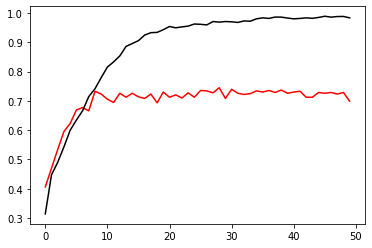

In [44]:
plt.plot(np.arange(len(history.history['val_accuracy'])), history.history['val_accuracy'], color='red')
plt.plot(np.arange(len(history.history['accuracy'])), history.history['accuracy'], color='black');

## Using tf.data for finer control

In [45]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
print(list_ds)

<TensorSliceDataset shapes: (), types: tf.string>


In [46]:
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [47]:
for f in list_ds.take(5):
    print(f.numpy())

b'flowers/roses/17158274118_00ec99a23c.jpg'
b'flowers/sunflowers/6166888942_7058198713_m.jpg'
b'flowers/dandelion/20983660733_06b35b9eb8.jpg'
b'flowers/daisy/2536529152_33ef3ee078_n.jpg'
b'flowers/dandelion/570127230_ce409f90f8_n.jpg'


In [48]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [49]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [50]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [51]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [52]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [53]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [54]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [55]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


In [56]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [57]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25
)

Epoch 1/25
92/92 [==============================] - 10s 84ms/step - loss: 0.4167 - accuracy: 0.9080 - val_loss: 0.2198 - val_accuracy: 0.9469
Epoch 2/25
92/92 [==============================] - 4s 48ms/step - loss: 0.2327 - accuracy: 0.9377 - val_loss: 0.2223 - val_accuracy: 0.9332
Epoch 3/25
92/92 [==============================] - 4s 48ms/step - loss: 0.1968 - accuracy: 0.9489 - val_loss: 0.1839 - val_accuracy: 0.9428
Epoch 4/25
92/92 [==============================] - 4s 48ms/step - loss: 0.1477 - accuracy: 0.9567 - val_loss: 0.2444 - val_accuracy: 0.9401
Epoch 5/25
92/92 [==============================] - 4s 48ms/step - loss: 0.1021 - accuracy: 0.9751 - val_loss: 0.2612 - val_accuracy: 0.9455
Epoch 6/25
92/92 [==============================] - 4s 48ms/step - loss: 0.0939 - accuracy: 0.9728 - val_loss: 0.2666 - val_accuracy: 0.9346
Epoch 7/25
92/92 [==============================] - 4s 48ms/step - loss: 0.0748 - accuracy: 0.9775 - val_loss: 0.2999 - val_accuracy: 0.9401
Epoch 8/25
9